In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import MeanShift, estimate_bandwidth

MIN_MATCH_COUNT = 3

In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [3]:
img = cv2.imread('train/train_2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

template = cv2.imread('train/template_2.jpg')
#template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

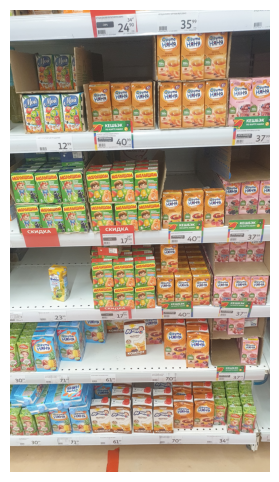

In [4]:
plot_img(img)

In [84]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN

def get_points(kp):
    res = np.array([kp[0].pt])
    for i in range(1, len(kp)):
        res = np.append(res, [kp[i].pt], axis=0)

    return res

def clasterize(points):
    bandwidth = estimate_bandwidth(points, quantile=0.1, n_samples=500)
    kluster = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
    kluster.fit(points)
    labels = kluster.labels_

    un_labels = np.unique(labels)
    clusters = len(un_labels)
    return clusters, labels

def divide(num_of_clusters, labels, kp):
    kluster = [None] * num_of_clusters
    for i in range(num_of_clusters):
        d, = np.where(labels == i)
        kluster[i] = list(kp[j] for j in d)
    return kluster

def detection(kp1, kp2, ddd, query, train):
    
    dst_pts = [ kp2[m.trainIdx].pt for m in ddd ]
    #print('pp', dst_pts[:10])
    #src_pts = np.float32([ kp1[m.queryIdx].pt for m in ddd ])
    clusters = DBSCAN(eps=100).fit_predict(dst_pts)
    uniq_clusters = np.unique(clusters)
    #print('un', uniq_clusters)
    sizes = {}
    for clus in uniq_clusters:
        d, = np.where(clusters == clus)
        sizes[clus] = len(clusters[d])
    #print("clus", sizes)
    
    ind, = np.where(max(sizes, key=sizes.get) == clusters)
    #print('ii', type(ind))
    
    maxclus = [ddd[i] for i in ind]
    
    if len(maxclus) <=3 :
        return []
    #print("maxclus", maxclus[:10])
    #print("clust", clusters[:10])
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in maxclus ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in maxclus ]).reshape(-1,1,2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)

    if M is None:
        return []
    
    h, w = query.shape
    corners = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, M)
    pts = np.int32(transformedCorners).reshape(8).tolist()
    x1, x2 = min(pts[1], pts[3], pts[5], pts[7]), max(pts[1], pts[3], pts[5], pts[7])
    y1, y2 = min(pts[0], pts[2], pts[4], pts[6]), max(pts[0], pts[2], pts[4], pts[6])
    if not np.isclose((x2 - x1) / h, (y2 - y1) / w, 0.2):
        return []
    
    train = cv2.fillPoly(train, [np.int32(transformedCorners)], 255)
    return [x1, y1, x2 - x1, y2 - y1]


def find_bboxes(kp1, kp2, des1, des2, flann):

    if(len(kp2)<2 or len(kp1)<2):
        return []

    matches = flann.knnMatch(des1, des2, 2)

    ddd = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            ddd.append(m)

    if len(ddd) <= 3:
        return []
    
    #return detection(kp1, kp2, ddd, query)
    return ddd
    

def predict_image(img: np.ndarray, query: np.ndarray) -> list:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    query = cv2.cvtColor(query, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(query, None)
    #kp2, des2 = sift.detectAndCompute(img, None)
    
    des1 = np.float32(des1)
    #des2 = np.float32(des2)

    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    #pt = get_points(kp2)
    #num_of_clusters, labels = clasterize(pt)

    #kluster = divide(num_of_clusters, labels, kp2)

    list_of_bboxes = []
    while True:
        #kp = kluster[i]
        #ind, = np.where(labels == i)
        #des = des2[ind, ]
        kp2, des2 = sift.detectAndCompute(img, None)
        des2 = np.float32(des2)
        bbox = find_bboxes(kp1, kp2, des1, des2, flann)
        #print(len(bbox))
        #print(bbox[:10])
        if len(bbox):
            res = detection(kp1, kp2, bbox, query, img)
            if len(res):
                print(res)
                list_of_bboxes.append(res)
            else:
                break
            #bbox[0] /= img.shape[0]
            #bbox[1] /= img.shape[1]
            #bbox[2] /= img.shape[0]
            #bbox[3] /= img.shape[1]
            #list_of_bboxes.append(bbox)
        else:
            break

    return list_of_bboxes

In [85]:
tmp = img.copy()
%time predict_image(tmp, template)

[1408, 1087, 259, 216]
[1414, 875, 258, 226]
[1681, 1115, 240, 211]
[1419, 662, 260, 239]
[2215, 713, 213, 202]
[1690, 916, 238, 215]
[2404, 1085, 207, 191]
[2215, 900, 208, 200]
[2204, 1090, 209, 194]
[2414, 906, 203, 192]
[1694, 700, 241, 222]
[2417, 724, 192, 193]
CPU times: user 55.7 s, sys: 5.03 s, total: 1min
Wall time: 1min 10s


[[1408, 1087, 259, 216],
 [1414, 875, 258, 226],
 [1681, 1115, 240, 211],
 [1419, 662, 260, 239],
 [2215, 713, 213, 202],
 [1690, 916, 238, 215],
 [2404, 1085, 207, 191],
 [2215, 900, 208, 200],
 [2204, 1090, 209, 194],
 [2414, 906, 203, 192],
 [1694, 700, 241, 222],
 [2417, 724, 192, 193]]

In [51]:
np.array([1,2])

array([1, 2])

In [177]:
d[0]

array([0, 4])

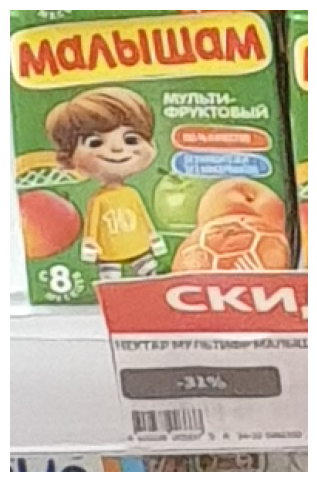

In [90]:
x = 2417
y = 724
plot_img(img[x:x+300, y:y+193])

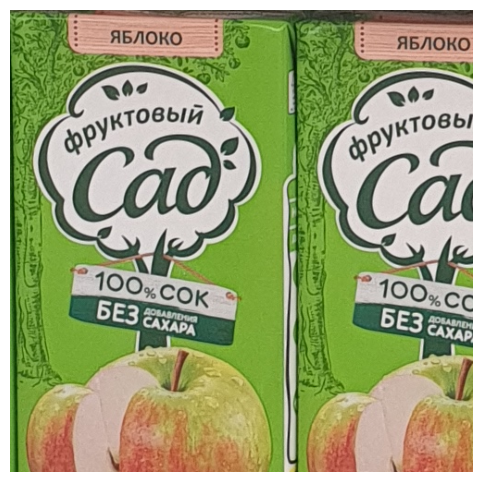

In [18]:
plot_img(img[1903:1903+500, 704:704+500])

In [22]:
np.int32(np.array([0.4, 5.6]))

array([0, 5], dtype=int32)

In [24]:
min(0, 5, -2)

-2

In [87]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
MIN_MATCH_COUNT = 4
FLANN_INDEX_KDTREE = 1
lowe_ind = 0.9
def sides(img, pts, h, w):
    # print(pts)
    yy = [pts[i] for i in range(0,7,2)]
    xx = [pts[i] for i in range(1,8,2)]
    x1 = min(xx)
    x2 = max(xx)
    y1 = min(yy)
    y2 = max(yy)
    img2 = img[x1:x2, y1:y2]
    h_n, w_n = img2.shape

    # print(w_n, h_n, w, h, w_n / w, h_n / h)
    return (np.isclose(h_n / h, w_n / w, 0.2)) 
def find_images(img, kp_q, des_q, query_shape, sift, flann):
    # find the keypoints and descriptors with SIFT
    kp2, des2 = sift.detectAndCompute(img, None)
    # print(des2)
    # des2 /= (des2.sum(axis=1, keepdims=True))
    # des2 = np.sqrt(des2)


    matches = flann.knnMatch(des_q, des2, k=2)
    good = []
    for i, (m,n) in enumerate(matches):
        if m.distance < lowe_ind * n.distance:
            good.append(m)
            # print(i,kp2[i].pt)
    # print(len(good))
    dst_pt = [ kp2[m.trainIdx].pt for m in good ]
    # print(set(dst_pt))
    labels = DBSCAN(eps=100).fit_predict(dst_pt)


    uniq = {}
    for pos, a in enumerate(labels):
        if not (a in uniq):
            uniq[a] = 1
        else:
            uniq[a] +=1

    # print(uniq)
    ready = []

    mink = max(uniq, key=uniq.get)
    # print("min", mink)
    for n, x in enumerate(labels): 
        if x == mink:
            ready.append(good[n])

    # print(db)
    # print(dst_pt)
    # print("ready", len(ready))
    if len(ready) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_q[m.queryIdx].pt for m in ready ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in ready ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist() 
        h,w = query_shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        pts_transformed = np.int32(dst).reshape(8).tolist()
        sides(img,pts_transformed, h, w)
        if (not sides(img,pts_transformed, h, w)):
            return [False, img, [-1, -1, -1, -1]]
        img2 = cv.fillPoly(img, [np.int32(dst)], 255)
        
        bbox = pts_transformed[:2] + pts_transformed[4:6]
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
        img3 = cv.drawMatches(img,kp_q,img2,kp2,ready,None,**draw_params)    
        # plt.imshow(img3, 'gray'),plt.show()
        # plt.imshow(img, 'gray'),plt.show()
        

        return [True, img2, bbox]
    else:
        return [False, img, [-1, -1, -1, -1]]
    
    

def predict_image(img: np.ndarray, query: np.ndarray) -> list:
    img  = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    query  = cv.cvtColor(query, cv.COLOR_RGB2GRAY)

    sift = cv.SIFT_create()
    kp_q, des_q = sift.detectAndCompute(query, None)
    # des_q /= (des_q.sum(axis=1, keepdims=True))
    # des_q = np.sqrt(des_q)

    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv.FlannBasedMatcher(index_params, search_params)
    res, new_img, bbox = find_images(img, kp_q, des_q, query.shape, sift, flann)
    list_of_bboxes = [ ]
    while (res):
        print(bbox)
        list_of_bboxes.append(bbox)
        res, new_img, bbox = find_images(new_img, kp_q, des_q, query.shape, sift, flann)

    # plt.imshow(new_img, 'gray'),plt.show()
    # print(list_of_bboxes)
    return list_of_bboxes

# img1 = cv.imread('data/template_3.jpg')          # queryImage
# img2 = cv.imread('data/train_3.jpg') # trainImage
# predict_image(img2, img1)

In [88]:
predict_image(img, template)

[1087, 1408, 1302, 1666]
[875, 1416, 1101, 1671]
[1118, 1684, 1323, 1919]
[662, 1424, 901, 1674]
[714, 2220, 916, 2413]
[1090, 2207, 1284, 2404]
[1091, 2414, 1278, 2599]
[915, 1692, 1129, 1926]
[899, 2218, 1100, 2414]
[699, 1693, 921, 1933]
[906, 2419, 1098, 2609]


[[1087, 1408, 1302, 1666],
 [875, 1416, 1101, 1671],
 [1118, 1684, 1323, 1919],
 [662, 1424, 901, 1674],
 [714, 2220, 916, 2413],
 [1090, 2207, 1284, 2404],
 [1091, 2414, 1278, 2599],
 [915, 1692, 1129, 1926],
 [899, 2218, 1100, 2414],
 [699, 1693, 921, 1933],
 [906, 2419, 1098, 2609]]

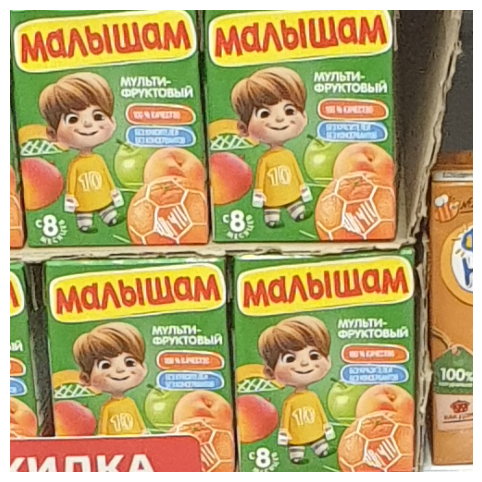

In [91]:
x = 1416
y = 875
plot_img(img[x:x+500, y:y+500])

In [157]:
d = {4:9, 5:5}

In [158]:
max(d.values())

9